## Cargo la superficie

Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/resampleo_trackfiles/trackfile6/surface_source.h5: 840686
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Peso total: 91799.6691
Cantidad de partículas: 452935
Macrogrupo 1: rango [2.996, 2.996) → peso = 40586.9, 44.21%
Cantidad de partículas con letargia mínima (2.996): 40573
Macrogrupo 2: rango [2.996, 3.000) → peso = 153.9, 0.17%
Macrogrupo 3: rango [3.000, 3.008) → peso = 159.9, 0.17%
Macrogrupo 4: rango [3.008, 3.019) → peso = 147.6, 0.16%
Macrogrupo 5: rango [3.019, 3.039) → peso = 221.0, 0.24%
Macrogrupo 6: rango [3.039, 3.076) → peso = 354.8, 0.39%
Macrogrupo 7: rango [3.076, 3.145) → peso = 514.1, 0.56%
Macrogrupo 8: rango [3.145, 3.195) → peso = 322.4, 0.35%
Macrogrupo 9: rango [3.195, 3.243) → peso = 261.4, 0.28%
Macrogrupo 10: rango [3.243, 3.311) → peso = 412.5, 0.45%
Macrogrupo 11: rango [3.311, 3.381) → peso = 384.2, 0.42%
Macrogrupo 12: rango [3.381, 3.476) → peso = 463.4, 0.50%
Macrogrupo 13: rango [3.476, 3.5

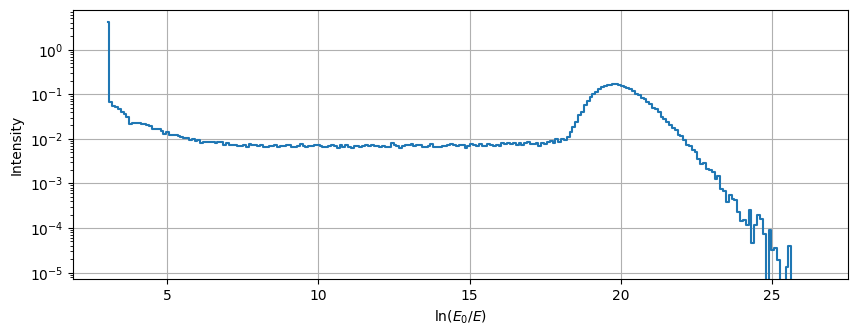

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kdsource.surfsource as kds
import kdsource.histograms as kdh

plt.close("all")

ss = kds.SurfaceSourceFile(
    # "/home/lucas/Documents/Proyecto_Integrador/PI/paralelepipedo/corrida17/surface_source_12500.h5",
    # "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/procesamiento/ssf_N17b_C5_trf.h5",
    "/home/lucas/Documents/Proyecto_Integrador/PI/resampleo_trackfiles/trackfile6/surface_source.h5",
    domain={"w": [0, 2]},
    # domain={"w": [0, 2],"x":[-1.5, 1.5],"y":[-1.5, 1.5]},
)

fine_bins = int(5e4)
var = "ln(E0/E)"

letargia = ss._df2[var].to_numpy()
pesos = ss._df2["wgt"].to_numpy()
print(f"Peso total: {pesos.sum():.4f}")
print(f"Cantidad de partículas: {len(letargia)}")


user_edges = [letargia.min() + 1e-9]
# user_edges = [1-1e-9]

edges = kdh._adaptive_edges(
    x=letargia,
    n_bins=100,
    w=pesos,
    initial_bins=1,
    fine_bins=fine_bins,
    # user_edges = user_edges,
)
# calcular suma de pesos en cada subgrupo definido por ‘edges’
pesos_subgrupos, _ = np.histogram(letargia, bins=edges, weights=pesos)
total = pesos.sum()

# imprimir el peso y porcentaje de cada macrogrupo
for i, (wgt, lo, hi) in enumerate(zip(pesos_subgrupos, edges[:-1], edges[1:]), start=1):
    pct = wgt / total * 100
    print(f"Macrogrupo {i}: rango [{lo:.3f}, {hi:.3f}) → peso = {wgt:.1f}, {pct:.2f}%")

    if i == 1:
        n_min = np.count_nonzero(letargia == letargia.min())
        print(
            f"Cantidad de partículas con letargia mínima ({letargia.min():.3f}): {n_min}"
        )

# %matplotlib widget

bin_width = (letargia.max() - letargia.min()) / fine_bins

plt.figure(figsize=(10, 3.5))
plt.grid()
ss.plot_distribution(
    vars=[var],
    bins=[int(fine_bins / 200)],
    scales=["linear", "log"],
    zlabel="Intensidad",
    factor=100000 / 714306 * 709528,
    errors=False,
)
# plt.xscale("log")
# for edge in edges:
#     plt.axvline(x=edge, linestyle="--", color="k")

# plt.hist(
#     letargia,
#     bins=edges,
#     weights=pesos*1e-12*1.38/2*3,
#     histtype='stepfilled',
#     color='red',
#     alpha=0.3,
#     # density=True,
# )
plt.show()


# plt.figure(figsize=(10, 5))
# plt.hist(edges, bins=100, histtype='step', color='k')
# plt.show()

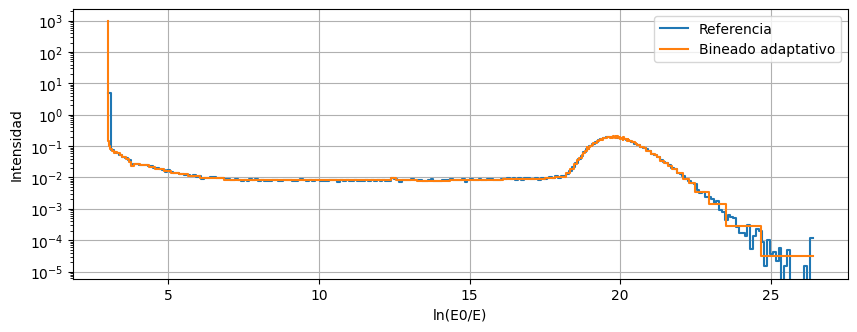

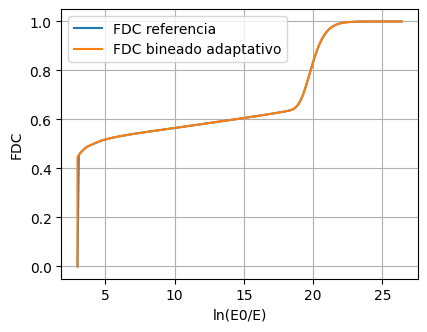

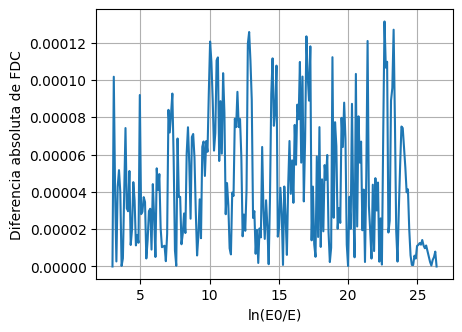

In [2]:
edges_fine = np.linspace(letargia.min(), letargia.max(), int(fine_bins/200))
# print(len(edges_fine))

counts_fine, _ = np.histogram(letargia, edges_fine, weights=pesos)
# print(len(counts_fine))

cfd_fine = np.cumsum(counts_fine)
counts_fine = counts_fine / counts_fine.sum() / (edges_fine[1]-edges_fine[0])
cfd_fine = cfd_fine / cfd_fine[-1]
cfd_fine = np.insert(cfd_fine, 0, 0)
# print(len(cfd_fine))

counts_gross, _ = np.histogram(letargia, edges, weights=pesos)
cfd_gross = np.cumsum(counts_gross)
counts_gross = counts_gross / counts_gross.sum() / np.diff(edges)
cfd_gross = cfd_gross / cfd_gross[-1]
cfd_gross = np.insert(cfd_gross, 0, 0)

plt.figure(figsize=(10, 3.5))
edges_plot = np.append(edges_fine, edges_fine[-1])  # agrega el último borde de bin
counts_plot = np.append(counts_fine, counts_fine[-1])  # repite el último valor
plt.step(edges_plot[:-1], counts_plot, where='post', label="Referencia")
edges_plot = np.append(edges, edges[-1])  # agrega el último borde de bin
counts_plot = np.append(counts_gross, counts_gross[-1])  # repite el último valor
plt.step(edges_plot[:-1], counts_plot, where='post', label='Bineado adaptativo')
plt.xlabel("ln(E0/E)")
plt.ylabel("Intensidad")
# plt.title("Histograma de letargía")
plt.grid(True)
plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(4.6, 3.5))
plt.plot(edges_fine, cfd_fine, label="FDC referencia")
plt.plot(edges, cfd_gross, label="FDC bineado adaptativo")
plt.grid(True)
plt.xlabel("ln(E0/E)")
plt.ylabel("FDC")
plt.legend()
plt.show()

cfd_gross_auxiliar = np.interp(edges_fine,edges,cfd_gross)
cfd_diff = np.abs(cfd_gross_auxiliar - cfd_fine)

plt.figure(figsize=(4.6, 3.5))
plt.plot(edges_fine, cfd_diff)
plt.grid(True)
plt.xlabel("ln(E0/E)")
plt.ylabel("Diferencia absoluta de FDC")
plt.show()